In [1]:
#pip install warnings

import warnings

# Suppress RuntimeWarning
warnings.filterwarnings("ignore", category=RuntimeWarning)


# Task 1  Dimensionality Reduction

In [2]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
import numpy as np
# Load the Labeled Faces in the Wild dataset
lfw_people = fetch_lfw_people(min_faces_per_person=30, resize=0.5)




## **Subtask 1 -  Data Loading and Data Preparation**

### REPORT
 
- Number of different people in the data: 34
- Number of images in the data: 2370
- Size of the images: (62, 47)
- plots of images provided below

Number of different people in the data: 34
Number of images in the data: 2370
Size of the images: (62, 47)


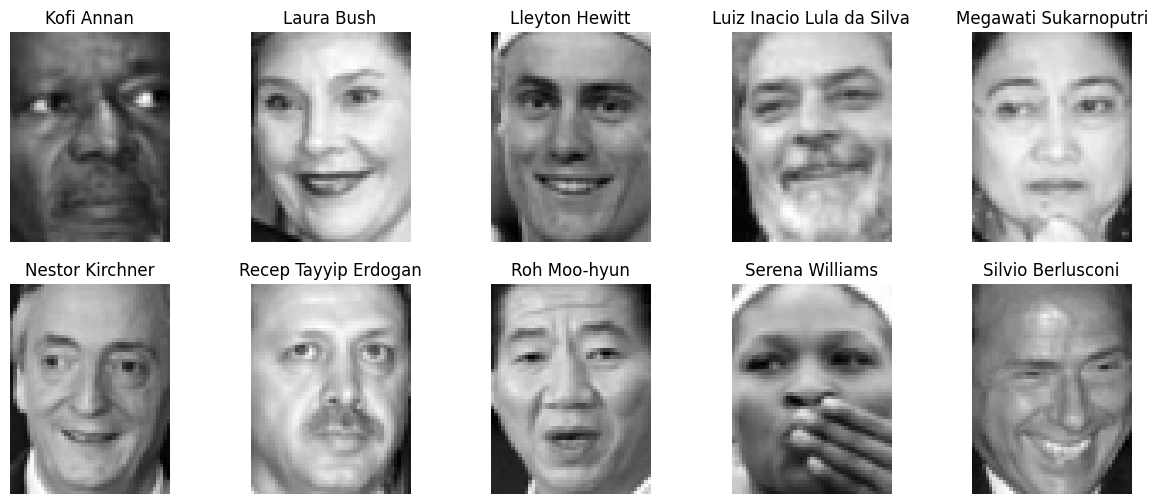

In [7]:
# Get information about the dataset
num_people = len(lfw_people.target_names)
num_images = lfw_people.images.shape[0]
image_size = lfw_people.images.shape[1:]

print(f"Number of different people in the data: {num_people}")
print(f"Number of images in the data: {num_images}")
print(f"Size of the images: {image_size}")

unique_people = np.unique(lfw_people.target, return_index=True)[1][20:30]

# Plot images of ten different people
fig, axes = plt.subplots(2, 5, figsize=(15, 6),
                         subplot_kw={'xticks': (), 'yticks': ()})

for i, idx in enumerate(unique_people):
    image_data = lfw_people.images[idx]
    person_name = lfw_people.target_names[lfw_people.target[idx]]
    axes[i // 5, i % 5].imshow(image_data, cmap="gray")
    axes[i // 5, i % 5].set_title(person_name)
    axes[i // 5, i % 5].axis("off")


plt.show()

In [53]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    lfw_people.data, lfw_people.target, test_size=0.3, stratify=lfw_people.target, random_state=42)

# Print the sizes of the training and validation sets
print(f"Number of samples in training set: {len(y_train)}")
print(f"Number of samples in validation set: {len(y_val)}")


Number of samples in training set: 1659
Number of samples in validation set: 711


## **Subtask 2 -  Dimensionality Reduction Using PCA**

#### **REPORT**

1.  The class PCA supports two methods for PCA: 'eigenvalues' and 'SVD'.
    - The fit method computes the principal directions and diagonal elements of the covariance matrix.
    - The transforming method projects data to a lower-dimensional space.
    - The reconstruct method reconstructs data from a low-dimensional representation back to high-dimensional space.
    - The class is designed to facilitate PCA computations and transformations.

2. and 3. are provided below

4. Logistic regression: 

    Accuracies - for eigenvalue decomosition the same as for SVD 

    * Number of components: 5 ===>     Training accuracy: 0.23809523809523808    ||  Validation accuracy: 0.24753867791842477

    * Number of components: 10 ===>     Training accuracy: 0.29294755877034356    ||  Validation accuracy: 0.28270042194092826

    * Number of components: 20 ===>     Training accuracy: 0.3779385171790235     ||  Validation accuracy: 0.3558368495077356

    * Number of components: 40 ===>     Training accuracy: 0.5732368896925859     ||  Validation accuracy: 0.49226441631504925

    * Number of components: 80  ===>    Training accuracy: 0.7510548523206751     ||  Validation accuracy: 0.5625879043600562

    *  **Number of components: 160  ===>   Training accuracy: 0.8812537673297167     ||  Validation accuracy: 0.60056258790436**

    * Number of components: 320  ===>    Training accuracy: 0.97166968053044       ||  Validation accuracy: 0.5710267229254571

    * Number of components: 640 ===>    Training accuracy: 1.0                    ||  Validation accuracy: 0.5218002812939522


5. The best accuracy achieved on validation set is with components =160. Basically, as the number of components increases, both training and validation accuracies generally improve or have not so high changes.
 

In [124]:
import numpy as np

class PCA:
    def __init__(self, n_components=1, method='eigenvalues'):
        self.n_components = n_components # Number of principal components to retain.
        self.method = method #Method used for PCA ('eigenvalues' or 'SVD').
        self.W = None  # Projection matrix
        self.S = None  # Diagonal elements of covariance matrix (for plotting)

    def fit(self, X):
        """
        Fits the PCA model to the input data
        """
        assert self.n_components <= X.shape[-1]
        if self.method == 'eigenvalues':
            # Empirical covariance matrix
            Sigma = X.T @ X

            # Eigenvalue decomposition
            eigen_vals, eigen_vecs = np.linalg.eig(Sigma)
            idx = np.argsort(eigen_vals)[::-1]
            eigen_vals = eigen_vals[idx]
            eigen_vecs = eigen_vecs[:, idx]

            # Principal directions.
            self.W = eigen_vecs[:, :self.n_components]

            # Calculate ellipse diagonals (only for plotting).
            self.S = np.sqrt(eigen_vals) / np.sqrt(X.shape[0])

        elif self.method == 'SVD':
            # Perform SVD factorization of matrix X.
            U, S, V = np.linalg.svd(X)

            # Get principal directions.
            self.W = V[:self.n_components].T

            # Calculate ellipse diagonals (only for plotting).
            self.S = S / np.sqrt(X.shape[0])

    def transforming(self, X):
        # Project to low-dimensional space
        return X @ self.W

    def reconstruct(self, Z):
        # Project back to high-dimensional space
        return Z @ self.W.T



In [132]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

def perform_pca_log_regress(X_train, y_train, X_val, y_val, components_list,method):

    """
    conducts PCA followed by logistic regression on training and validation datasets for various numbers of principal components. It uses a specified method for PCA, such as eigenvalues or SVD. The function returns a dictionary containing the training and validation accuracies for each number of components.

    Parameters:

    X_train: Training data.
    y_train: Training labels.
    X_val: Validation data.
    y_val: Validation labels.
    components_list: A list of numbers specifying the desired principal components to be evaluated.
    method: The method used for PCA ('eigenvalues' or 'SVD').
    """
    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()

    # dictionary to store the accuracy for each number of components
    accuracy = {}

    for d in components_list:
        #initialize PCA with the number of components
        pca = PCA(d, method)
        pca.fit(X_train)

        # Transform the data
        X_train_pca = pca.transforming(X_train)
        X_val_pca = pca.transforming(X_val)

        # Normalize the data
        X_train_pca = scaler.fit_transform(X_train_pca)
        X_val_pca = scaler.transform(X_val_pca)

        #logistic regression classifier
        clf = LogisticRegression(max_iter=1000)

        # Train
        clf.fit(X_train_pca, y_train)

        #predicting the labels of the training and validation data
        y_train_pred = clf.predict(X_train_pca)
        y_val_pred = clf.predict(X_val_pca)

        # Compute the accuracy of the classifier
        train_accuracy = accuracy_score(y_train, y_train_pred)
        val_accuracy = accuracy_score(y_val, y_val_pred)

        accuracy[d] = (train_accuracy, val_accuracy)

        print(f"Number of components: {d}")
        print(f"Training accuracy: {train_accuracy}")
        print(f"Validation accuracy: {val_accuracy}\n")

    return accuracy

#### SVD method

In [129]:

components_list = [5, 10, 20, 40, 80, 160, 320, 640]
accuracy_results = perform_pca_log_regress(X_train, y_train, X_val, y_val, components_list,method='SVD')


Number of components: 5
Training accuracy: 0.23809523809523808
Validation accuracy: 0.24753867791842477

Number of components: 10
Training accuracy: 0.29294755877034356
Validation accuracy: 0.28270042194092826

Number of components: 20
Training accuracy: 0.3779385171790235
Validation accuracy: 0.3558368495077356

Number of components: 40
Training accuracy: 0.5732368896925859
Validation accuracy: 0.49226441631504925

Number of components: 80
Training accuracy: 0.7510548523206751
Validation accuracy: 0.5625879043600562

Number of components: 160
Training accuracy: 0.8812537673297167
Validation accuracy: 0.60056258790436

Number of components: 320
Training accuracy: 0.97166968053044
Validation accuracy: 0.5710267229254571

Number of components: 640
Training accuracy: 1.0
Validation accuracy: 0.5218002812939522



#### eigenvalue decomposition

In [133]:
accuracy_results = perform_pca_log_regress(X_train, y_train, X_val, y_val, components_list,method='eigenvalues')

C:\Users\agnie\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


Number of components: 5
Training accuracy: 0.23809523809523808
Validation accuracy: 0.24753867791842477



C:\Users\agnie\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


Number of components: 10
Training accuracy: 0.29294755877034356
Validation accuracy: 0.28270042194092826



C:\Users\agnie\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


Number of components: 20
Training accuracy: 0.378541289933695
Validation accuracy: 0.3558368495077356



C:\Users\agnie\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


Number of components: 40
Training accuracy: 0.5732368896925859
Validation accuracy: 0.49226441631504925



C:\Users\agnie\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


Number of components: 80
Training accuracy: 0.7510548523206751
Validation accuracy: 0.5625879043600562



C:\Users\agnie\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


Number of components: 160
Training accuracy: 0.8812537673297167
Validation accuracy: 0.60056258790436



C:\Users\agnie\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


Number of components: 320
Training accuracy: 0.97166968053044
Validation accuracy: 0.5710267229254571



C:\Users\agnie\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt


Number of components: 640
Training accuracy: 1.0
Validation accuracy: 0.5218002812939522



#### visualizing accuracies 

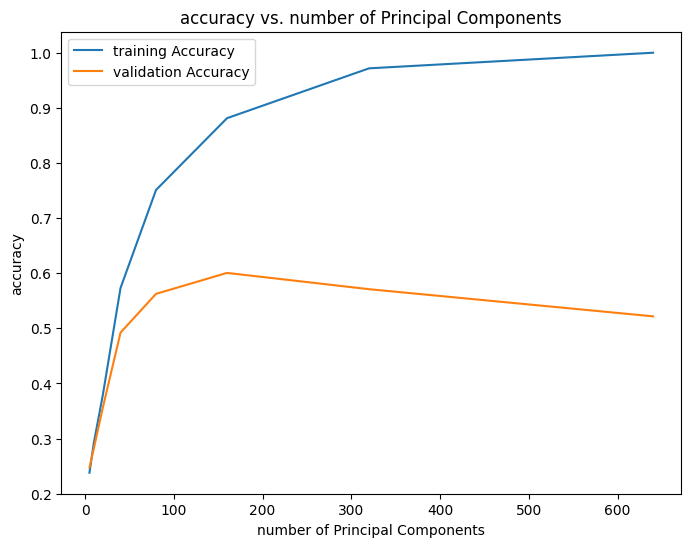

In [175]:

component_numbers = list(accuracy_results.keys())
train_accuracies = [result[0] for result in accuracy_results.values()]
val_accuracies = [result[1] for result in accuracy_results.values()]


plt.figure(figsize=(8, 6))
plt.plot(component_numbers, train_accuracies, label='training Accuracy')
plt.plot(component_numbers, val_accuracies, label='validation Accuracy')
plt.xlabel('number of Principal Components')
plt.ylabel('accuracy')
plt.title('accuracy vs. number of Principal Components')
plt.legend()
plt.show()


## Subtask 3 -  Dimensionality Reduction Using Autoencoders

#### **REPORT**

1) visualizations of 10 reconstructed images for 2 architectures can be seen below. 
2) classification accuracies:
- Architecture 1, d=40 with hidden layers: (500, 800, 40 * 3, 800, 500)===> Train accuracy: 0.50, Validation accuracy: 0.45
- Architecture 2, d=80 with hidden layers: (400,500, 80 * 3,500,400)===> Train accuracy: 0.65, Validation accuracy: 0.53

3) when the number of dimension is bigger, we achieve higher accuracy, as hidden layers are bigger, the computation time also increases.  In my case, architecture 2 is a better option, as its validation accuracy is 53%. By experimenting with hidden layers we could achieve even better results. 

4) Comparing results using PCA, where the best option was to choose d=160 (Training accuracy: 0.8812537673297167, Validation accuracy: 0.60056258790436). In the case of autoencoder we can compare results for d=40 and d=80 with those from PCA: 

    a1. Autoencoder d=40  ===> Train accuracy: 0.50, Validation accuracy: 0.45

    a2. PCA d=40 ===> Training accuracy: 0.5732368896925859, Validation accuracy: 0.49226441631504925

    b1. Autoencoder d=80 ===> Train accuracy: 0.65, Validation accuracy: 0.53

    b2. PCA d=80 ===>  Training accuracy: 0.7510548523206751, Validation accuracy: 0.5625879043600562


The autoencoder method generally achieves results similar to PCA. But autoencoders require training and may take advantage of large labeled datasets.
PCA does not require explicit training and can be applied directly to the data.  PCA provides a clear interpretation of principal components, which represent directions of maximum variance in the data. Autoencoders, being neural networks, might be less interpretable due to their complex architecture.


In [142]:
def encode(X, mlp):
    z = X
    for i in range(len(mlp.coefs_) // 2):
        z = z @ mlp.coefs_[i] + mlp.intercepts_[i]
        z = np.maximum(z, 0)
    return z

def decode(Z, mlp):
    z = Z
    for i in range(len(mlp.coefs_) // 2, len(mlp.coefs_)):
        z = z @ mlp.coefs_[i] + mlp.intercepts_[i]
        if i < len(mlp.coefs_) - 1:
            z = np.maximum(z, 0)
    return z

In [145]:
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

def train_and_evaluate(X_train, y_train, X_val, y_val, hidden_sizes, ds):
    """
    The train_and_evaluate function is used to train and evaluate a logistic regression classifier on top of an autoencoder for different values of the bottleneck size d. The function takes in five arguments:

    X_train: The training data
    y_train: The training labels
    X_val: The validation data
    y_val: The validation labels
    hidden_sizes: A list of tuples representing the number of neurons in each hidden layer of the autoencoder
    ds: A list of bottleneck sizes d to evaluate
    """
    # Initialize MinMaxScaler
    scaler = MinMaxScaler()

    # Initialize lists to store accuracies
    train_accuracies = []
    val_accuracies = []

    # Initialize lists to store reconstructed images for visualization
    reconstructed_images = []

    # Iterate over the values of d
    for d, hidden_size in zip(ds, hidden_sizes):
        # Train autoencoder
        mlp = MLPRegressor(hidden_layer_sizes=hidden_size, activation='relu', max_iter=500, random_state=42)
        mlp.fit(X_train, X_train)

        # Project and reconstruct images
        encoded_images = encode(X_val, mlp)
        decoded_images = decode(encoded_images, mlp)
        reconstructed_images.append(decoded_images[:10])

        # Project the data
        X_train_encoded = encode(X_train, mlp)
        X_val_encoded = encode(X_val, mlp)

        # Normalize the data
        X_train_scaled = scaler.fit_transform(X_train_encoded)
        X_val_scaled = scaler.transform(X_val_encoded)

        # Train logistic regression classifier
        clf = LogisticRegression(max_iter=1000, random_state=42)
        clf.fit(X_train_scaled, y_train)

        # Predict on the training and validation set
        y_train_pred = clf.predict(X_train_scaled)
        y_val_pred = clf.predict(X_val_scaled)

        # Compute accuracies
        train_accuracy = accuracy_score(y_train, y_train_pred)
        val_accuracy = accuracy_score(y_val, y_val_pred)

        # Append accuracies
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"For d={d}, Train accuracy: {train_accuracy:.2f}, Validation accuracy: {val_accuracy:.2f}")


    return train_accuracies, val_accuracies, reconstructed_images


# hidden layer sizes for two different architectures
ds = [40, 80]
a1, b1, a2, b2 = 500, 800, 400, 500
hidden_sizes = [(a1, b1, ds[0] * 3, b1, a1), (a2, b2, ds[1] * 3, b2, a2)]

# Call the function
train_accuracies, val_accuracies, reconstructed_images = train_and_evaluate(X_train, y_train, X_val, y_val, hidden_sizes, ds)


For d=40, Train accuracy: 0.50, Validation accuracy: 0.45
For d=80, Train accuracy: 0.65, Validation accuracy: 0.53


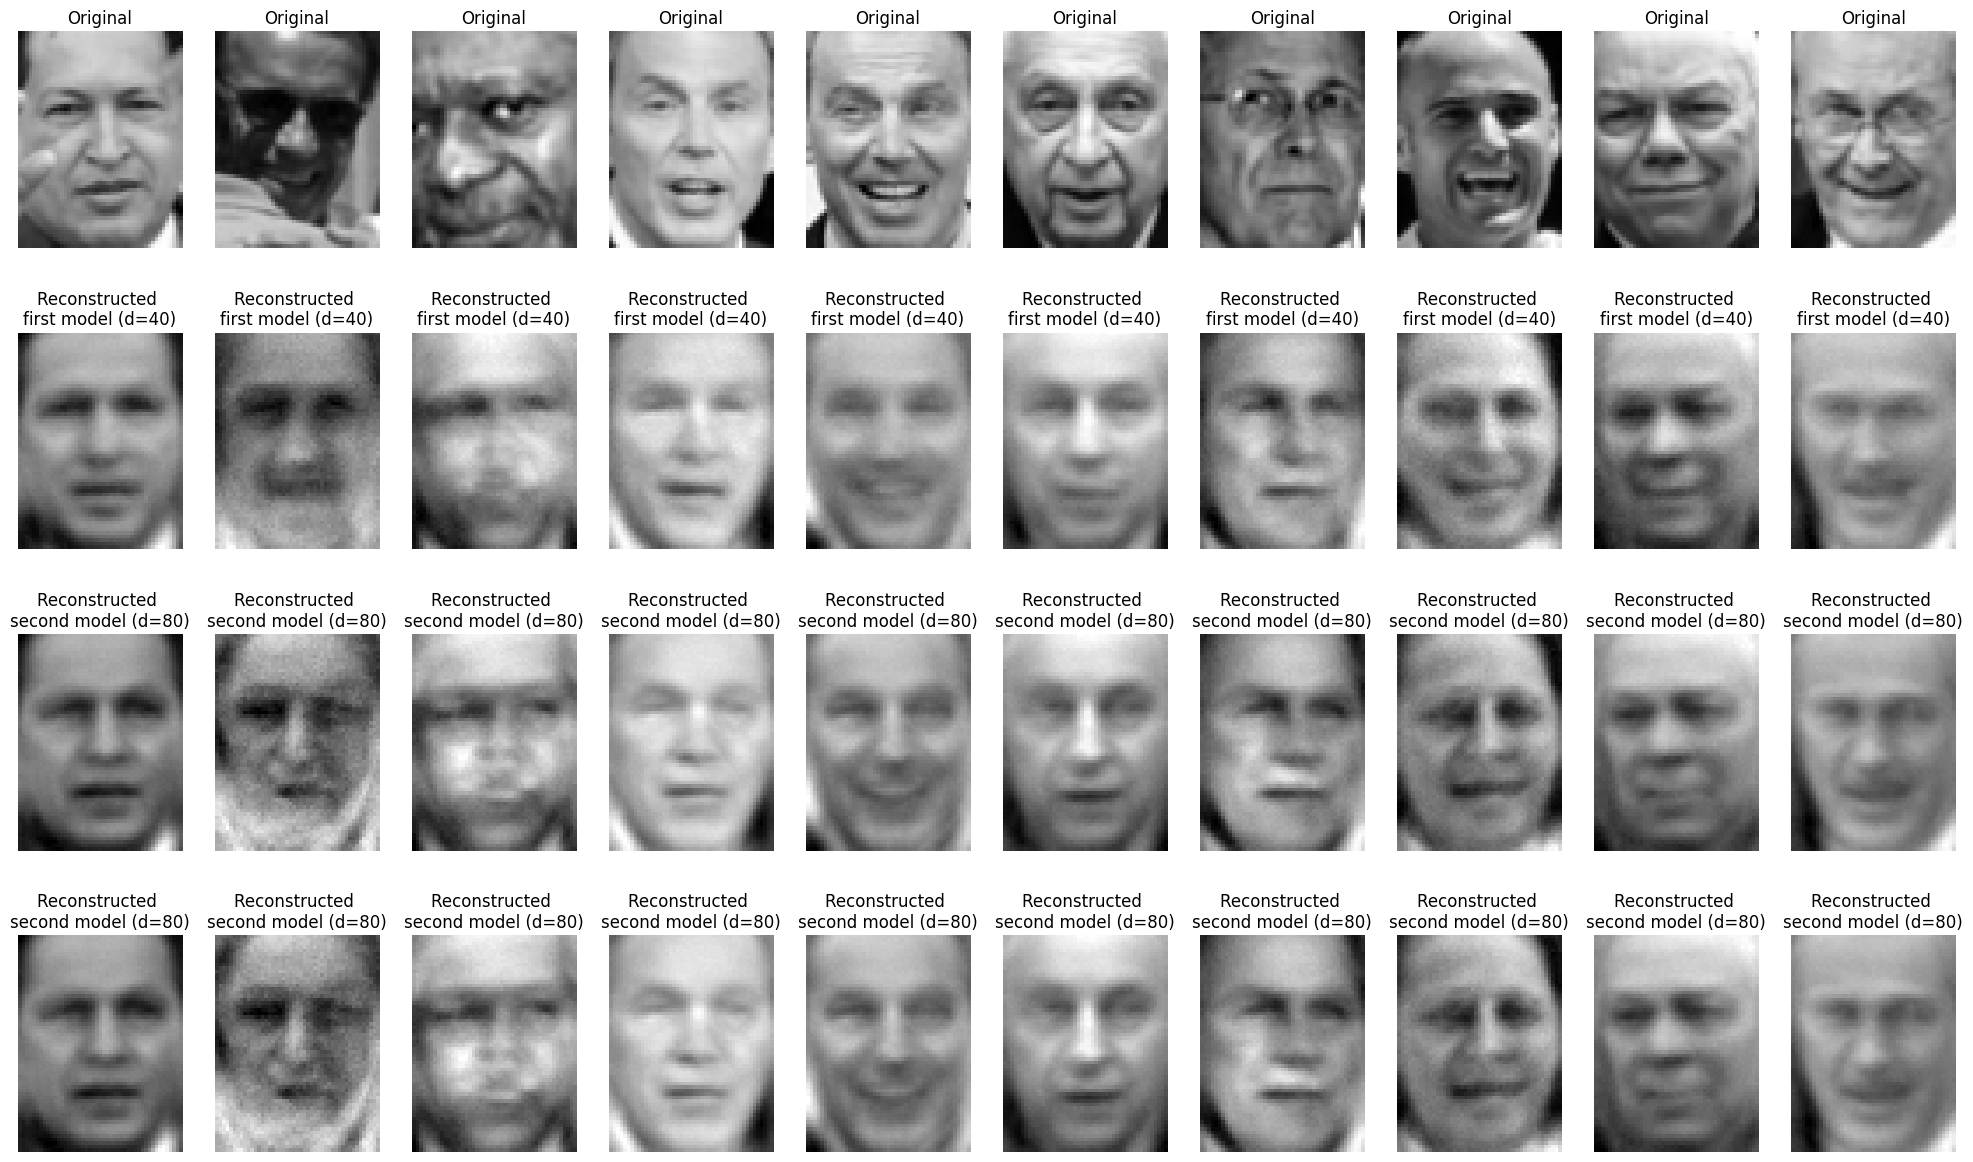

In [152]:
# Visualize 10 reconstructed images for each d and architecture
fig, axes = plt.subplots(4, 10, figsize=(25, 15))

for i in range(10):
     # Display the original image
    axes[0, i].imshow(X_val[i].reshape(image_size), cmap=plt.cm.gray)
    axes[0, i].axis('off')
    axes[0, i].set_title("Original")

    # Display the reconstructed image from the first model 
    axes[1, i].imshow(reconstructed_images[0][i].reshape(image_size), cmap=plt.cm.gray)
    axes[1, i].axis('off')
    axes[1, i].set_title(f"Reconstructed \nfirst model (d={40})")

    # Display the reconstructed image from the second model 
    axes[2, i].imshow(reconstructed_images[1][i].reshape(image_size), cmap=plt.cm.gray)
    axes[2, i].axis('off')
    axes[2, i].set_title(f"Reconstructed \nsecond model (d={80})")

    axes[3, i].imshow(reconstructed_images[1][i].reshape(image_size), cmap=plt.cm.gray)
    axes[3, i].axis('off')
    axes[3, i].set_title(f"Reconstructed \nsecond model (d={80})")

plt.show()